In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pybullet as p
import pybullet_data
import time
import random
import cv2
from decimal import Decimal
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [5]:
# Bicycle and its environment

#del env
cv2.destroyAllWindows()

class CycleBalancingEnv(gym.Env):
    metadata = {'render.modes': ['human']}  
  
    def __init__(self):
        # Out cycle has only 2 action spaces i.e. Torque of the wheels and the position of the handlebar
        self.action_space = gym.spaces.box.Box(
            low=-1 * np.ones(1, dtype=np.float32),
            high=1 * np.ones(1, dtype=np.float32))
        # Obervation space
        self.observation_space = gym.spaces.box.Box(
            low=-1 * np.ones(24, dtype=np.float32),
            high=1 * np.ones(24, dtype=np.float32))
        self.np_random, _ = gym.utils.seeding.np_random()

        if not p.isConnected():
            self.client = p.connect(p.GUI)
        else:
            self.client = 1
        #self.client = p.connect(p.SHARED_MEMORY)        
        #self.client = p.connect(p.DIRECT)
        
        self.n_target = 400
        self.min_target_dist = 10
        self.target_span = 80
        self.sphere_dist = 1.5
        self.pole = []
        p.resetSimulation(self.client)
        p.setRealTimeSimulation(0)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        self.plane=p.loadURDF("plane.urdf",[0,0,0], useFixedBase=True)
        self.bike = 0
        self.angle_span = 20
        self.n_episodes = 0
        
        self.make_obstacles()
        self.reset()
        #self.show_img()
        
    def show_img(self):
        
        self.img = np.zeros((800,800,3), dtype='float32')
        shift = 400
        multiply = 400
        ls = p.getBasePositionAndOrientation(self.bike)
        bike_x = ls[0][0]
        bike_y = ls[0][1]
        handlebar_rotation = p.getEulerFromQuaternion( p.getLinkState(self.bike, 0)[1] )[2]
        mini = 1000
        for deg in range(1, 361, 1):
            mini = min(mini, self.dist[deg-1])
            if deg%self.angle_span==0:
                rad = Decimal( Decimal(deg * np.pi/180 + handlebar_rotation)%Decimal(2*np.pi) + Decimal(2*np.pi))%Decimal(2*np.pi)
                rad = float(rad)
                #p.removeBody(self.sphere[cnt])
                #self.sphere[cnt] = p.loadURDF('sphere_small.urdf', [bike_x + self.sphere_dist*np.cos(rad), bike_y + self.sphere_dist*np.sin(rad), 1], [0,0,0,1])
                #cnt += 1
                start = (int(shift + bike_x + self.sphere_dist*np.cos(rad)), int(shift + bike_y + self.sphere_dist*np.sin(rad)))
                end = (int(shift + bike_x + mini*multiply*np.cos(rad)), int(shift + bike_y + mini*multiply*np.sin(rad)))
                #cv2.line(self.img, start, end, (0,0,255), 10)
                cv2.ellipse(self.img, start, (int(mini*multiply),int(mini*multiply)), 0, (rad*180/np.pi)-self.angle_span, (rad*180/np.pi), (0,0,255), -1)
                mini = 1000
            
        #cv2.destroyAllWindows()
        cv2.imshow('img', cv2.rotate(cv2.transpose(self.img), cv2.ROTATE_180))
        #cv2.imshow('img', self.img)
        cv2.waitKey(1)
        #cv2.destroyAllWindows()

    def step(self, action):
        
        p.setJointMotorControl2(self.bike, 0, p.POSITION_CONTROL, targetPosition=action[0], maxVelocity=5) # Apply Position control to Handlebar
        for i in range(3):
            p.setJointMotorControl2(self.bike,1,p.TORQUE_CONTROL , force=(3+0)*10000) # Apply Toruqe to Back Wheel
            p.setJointMotorControl2(self.bike,2,p.TORQUE_CONTROL , force=(3+0)*10000) # Apply Toruqe to Front Wheel
            ls = p.getBasePositionAndOrientation(self.bike) # ls[0]=Postion of cycle, ls[1] = Orientation of cycle
            val = p.getEulerFromQuaternion(ls[1])[0] - 1.57 # Calculating inclination of cycle from vertical
            p.applyExternalTorque(self.bike, -1, [-1000000*val, 0, 0], flags=p.WORLD_FRAME)
            p.stepSimulation()
        
        #p.applyExternalTorque(self.bike, -1, [-1000000*val, 0, 0], flags=p.WORLD_FRAME)
        
        #p.applyExternalTorque(self.bike, -1, [-20000*action[2], 0, 0], flags=p.LINK_FRAME)
        #p.setJointMotorControl2(self.bike, 3, p.POSITION_CONTROL, targetPosition=action[2], maxVelocity=100)
        #ls_tmp = p.getLinkState(self.bike, 3)
        #p.applyExternalForce(self.bike, 3, [0,0,10000], ls_tmp[2], p.LINK_FRAME)
        
#         ls = p.getBasePositionAndOrientation(self.bike) # ls[0]=Postion of cycle, ls[1] = Orientation of cycle
#         val = p.getEulerFromQuaternion(ls[1])[0] - 1.57 # Calculating inclination of cycle from vertical
# #         reward_1 = (abs(val)) * -1 # Calculae reward based on the angle of inclination
        
#         p.applyExternalTorque(self.bike, -1, [-1000000*val, 0, 0], flags=p.WORLD_FRAME)
        
        
            #p.stepSimulation()
        
#         if abs(val)>1:
#             reward_1 = (abs(val)) * -10
#         if abs(val)>1: # Terminate the episode if the angle of inclination from vertical is greater than 1.2 radian i.e 70 degree 
#             self.done=True
#             reward_1 = -200
            
        tmp = ls[0]
        self.bike_x = tmp[0]
        self.bike_y = tmp[1]
        
        # Calculating the position, orientation, velocity of all the joints of the cycle
        obs = []
#         for i in range(p.getNumJoints(self.bike)):
#             ls = p.getLinkState(self.bike, i, computeLinkVelocity=1, computeForwardKinematics=1)
#             for x in ls:
#                 for val in x:
#                     obs.append(val)
        ls = p.getBasePositionAndOrientation(self.bike)
        obs += ls[0] + p.getEulerFromQuaternion(ls[1])
        
        bike_x = ls[0][0]
        bike_y = ls[0][1]
        reward_2 = 0
        #cnt = 0
        ray_from = []
        ray_to = []
        handlebar_rotation = p.getEulerFromQuaternion( p.getLinkState(self.bike, 0)[1] )[2]
        for deg in range(1, 361, 1):
            rad = Decimal( Decimal(deg * np.pi/180 + handlebar_rotation)%Decimal(2*np.pi) + Decimal(2*np.pi))%Decimal(2*np.pi)
            rad = float(rad)
            #p.removeBody(self.sphere[cnt])
            #self.sphere[cnt] = p.loadURDF('sphere_small.urdf', [bike_x + self.sphere_dist*np.cos(rad), bike_y + self.sphere_dist*np.sin(rad), 1], [0,0,0,1])
            #cnt += 1
            ray_from.append((bike_x + self.sphere_dist*np.cos(rad), bike_y + self.sphere_dist*np.sin(rad), 1))
            ray_to.append((bike_x + 50*np.cos(rad), bike_y + 50*np.sin(rad), 1))
        
        rays = p.rayTestBatch(ray_from, ray_to)
        mini = 1000
        self.dist = []
        mini = 1000
        assert(len(rays)==360)
        minimum = 1000
        for deg in range(1, 361, 1):
            tmp = rays[deg-1]
            dist = tmp[2]
            minimum = min(minimum, dist)
            if dist<mini:
                mini = dist
            self.dist.append(dist)
            if deg%self.angle_span==0:
                obs.append(mini)
                mini = 1000
    
        tmp = p.getContactPoints(self.bike)
        for i in range(len(tmp)):
            if tmp[i][2]!=0:
                reward_2 = -100
                self.done = True
        
        self.time += 1 # Adding 1 to the time for which the current episode has been running
        
        # Terminating the episode if the cycle covers less than 1 units distance in 200 timesteps
        dist_2 = np.sqrt((self.bike_x)**2 + abs(self.bike_y)**2)
        if self.time%10==0 and dist_2>self.distance: self.distance = dist_2
        
        value = p.getEulerFromQuaternion(p.getLinkState(self.bike, 0)[1])[2] - p.getEulerFromQuaternion(ls[1])[2]
        if value<-1: value += 2*np.pi
        if value>1: value -= 2*np.pi
        #print(value)
        if value < -0.5:
            self.left += 0.1
            self.right = 0
        elif value > 0.5:
            self.left = 0
            self.right += 0.1
        else:
            self.left = 0
            self.right = 0
            
        self.neg_reward = 0
        if self.left>10 or self.right>10:
            print("Slow!!!")
            self.neg_reward = -100
            self.done = True
            
        if self.done:
            print(self.left, self.right, dist_2)
            
            
        # Terminating the episode if the cycle is more than 80units distance from the origin
        val = self.target_span
        reward_1 = 0
        if dist_2 > self.target_dist:
            reward_1 = 100 + self.target_reward
            self.target_dist += 10
            self.target_reward = min(500, self.target_reward*2)
            
        self.completed = 0
        if dist_2 > val:
            self.completed = 1
            self.done = True
            self.make_obstacles()
        
        # Calculating the total reward
        reward = reward_1 + reward_2 + max(-10, (dist_2-self.distance)) + self.time/1000 + self.neg_reward - self.left - self.right # - (1/(minimum+0.01))/10 # - abs(action[0])
        #print(mini, end=" ")
        
#         obs.append(self.time)
#         obs.append(self.cnt)
#         obs.append(self.left)
#         obs.append(self.right)
#         obs.append(action[0])
#         obs.append(dist_2)
#         obs.append(self.distance)

        obs = np.array(obs, dtype=np.float32)
        obs[0] /= self.target_span
        obs[1] /= self.target_span
        #print(obs.shape)
        
#         if self.time%50==10:
#             for deg in range(-90, 90, 5):
#                 rad = deg * np.pi/180 + p.getEulerFromQuaternion( p.getLinkState(self.bike, 0)[1] )[2] + 2*np.pi
#                 self.sphere.append(p.loadURDF('sphere_small.urdf', [bike_x + (self.sphere_dist+1*rad)*np.cos(rad), bike_y + (self.sphere_dist+1*rad)*np.sin(rad), 1], [0,0,0,1], useFixedBase=True, globalScaling=(deg+90)/10))
#             #time.sleep(5.0)
#         if self.time%50==40 or self.done:
#             for i in self.sphere:
#                 p.removeBody(i)
#             #time.sleep(5.0)

#         if self.time%10==0 and not self.done:
#             self.show_img()

        return obs, reward/100, self.done, dict()


    def reset(self):
        
        self.n_episodes += 1
        if self.n_episodes==20:
            self.make_obstacles()
            self.n_episodes = 0
        
        #p.resetSimulation(self.client)
        #p.setRealTimeSimulation(0)
        #p.setAdditionalSearchPath(pybullet_data.getDataPath())
        
        # Loading the plane
        #self.plane=p.loadURDF("plane.urdf",[0,0,0], useFixedBase=True)
        
        if self.bike!=0:
            p.removeBody(self.bike)
        # Loading the cycle
        self.bike_x = 0 # random.randint(-5, 5) # X position of the cycle
        self.bike_y = 0 # random.randint(-5, 5) # Y position of the cycle
        self.bike=p.loadURDF("../bike_2.urdf.xml",[self.bike_x, self.bike_y,1], p.getQuaternionFromEuler([0,0, random.random()*2*np.pi]),  useFixedBase=False)
            
        # Loading the target
#         self.pole = []
#         for i in range(self.n_target):
#             target_x = self.bike_x
#             target_y = self.bike_y
#             while (np.sqrt( (self.bike_x - target_x)**2 + (self.bike_y - target_y)**2 )) < self.min_target_dist:
#                 target_x = random.randint(int(self.bike_x) - self.target_span, int(self.bike_x) + self.target_span)
#                 target_y = random.randint(int(self.bike_y) - self.target_span, int(self.bike_y) + self.target_span)
#             self.pole.append( p.loadURDF("cube.urdf",[target_x, target_y, 1], [0,0,0,1], useFixedBase=True, globalScaling=3.0) )
        
        # Adding friction and other dynamics
        p.changeDynamics(self.plane, -1, lateralFriction=5, angularDamping=1)
        p.changeDynamics(self.bike, 1, mass=100)
        #p.changeDynamics(self.bike, 2, mass=100, lateralFriction=1, angularDamping=3, rollingFriction=0.01)
        p.changeDynamics(self.bike, -1, lateralFriction=5, angularDamping=1)
        
        p.setGravity(0, 0, -250) # Setting the gravity
        #p.setRealTimeSimulation(0)
        self.done=False
        self.time = 0
        self.distance = np.sqrt((self.bike_x)**2 + abs(self.bike_y)**2)
        self.neg_reward = 0
        
        # Calculating the initial observation space
        obs = []
#         for i in range(p.getNumJoints(self.bike)):
#             ls = p.getLinkState(self.bike, i, computeLinkVelocity=1, computeForwardKinematics=1)
#             for x in ls:
#                 for val in x:
#                     obs.append(val)
        ls = p.getBasePositionAndOrientation(self.bike)
        obs += ls[0] + p.getEulerFromQuaternion(ls[1])
        
        bike_x = ls[0][0]
        bike_y = ls[0][1]
        self.sphere = []
        mini = 1000
        handlebar_rotation = p.getEulerFromQuaternion( p.getLinkState(self.bike, 0)[1] )[2]
        for deg in range(1, 361, 1):
            rad = Decimal( Decimal(deg * np.pi/180 + handlebar_rotation)%Decimal(2*np.pi) + Decimal(2*np.pi))%Decimal(2*np.pi)
            rad = float(rad)
            #p.loadURDF('sphere_small.urdf', [bike_x + self.sphere_dist*np.cos(rad), bike_y + self.sphere_dist*np.sin(rad), 1], [0,0,0,1])
            #p.loadURDF('sphere_small.urdf', [bike_x + (self.sphere_dist+1*rad)*np.cos(rad), bike_y + (self.sphere_dist+1*rad)*np.sin(rad), 1], [0,0,0,1], useFixedBase=True, globalScaling=deg/10)
            #p.loadURDF('sphere_small.urdf', [bike_x + 10*np.cos(rad), bike_y + 10*np.sin(rad), 1], [0,0,0,1])
            tmp = p.rayTest((bike_x + self.sphere_dist*np.cos(rad), bike_y + self.sphere_dist*np.sin(rad), 1), (bike_x + 50*np.cos(rad), bike_y + 50*np.sin(rad), 1))[0]
            dist = tmp[2]
            if dist<mini:
                mini = dist
                angle = rad
            if deg%self.angle_span==0:
                obs.append(mini)
                mini = 1000
        
        self.cnt = 0
        self.left = 0
        self.right = 0
        self.target_dist = 10
        self.target_reward = 32
        self.completed = 0
#         obs.append(self.time)
#         obs.append(self.cnt)
#         obs.append(self.left)
#         obs.append(self.right)
#         obs.append(0)
#         obs.append(0)
#         obs.append(self.distance)
        
        obs = np.array(obs, dtype=np.float32)
        obs[0] /= self.target_span
        obs[1] /= self.target_span
        return obs

    def make_obstacles(self):
        
        p.resetSimulation(self.client)
        p.setRealTimeSimulation(0)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        self.plane=p.loadURDF("plane.urdf",[0,0,0], useFixedBase=True)
        self.bike = 0
        
#         for i in self.pole:
#             p.removeBody(i)
            
        self.bike_x = 0
        self.bike_y = 0
        self.pole = []
        for i in range(self.n_target):
            target_x = self.bike_x
            target_y = self.bike_y
            while (np.sqrt( (self.bike_x - target_x)**2 + (self.bike_y - target_y)**2 )) < self.min_target_dist:
                target_x = random.randint(int(self.bike_x) - self.target_span, int(self.bike_x) + self.target_span)
                target_y = random.randint(int(self.bike_y) - self.target_span, int(self.bike_y) + self.target_span)
            self.pole.append( p.loadURDF("cube.urdf",[target_x, target_y, 1], [0,0,0,1], useFixedBase=True, globalScaling=1.0) )
        
    def render(self, mode='human'):
            
        #p.stepSimulation()
        
        distance=5
        yaw = 0
        humanPos, humanOrn = p.getBasePositionAndOrientation(self.bike)
        humanBaseVel = p.getBaseVelocity(self.bike)
        #print("frame",frame, "humanPos=",humanPos, "humanVel=",humanBaseVel)
        camInfo = p.getDebugVisualizerCamera()
        curTargetPos = camInfo[11]
        distance=camInfo[10]
        yaw = camInfo[8]
        pitch=camInfo[9]
        targetPos = [0.95*curTargetPos[0]+0.05*humanPos[0],0.95*curTargetPos[1]+0.05*humanPos[1],curTargetPos[2]]
        
        p.resetDebugVisualizerCamera(distance,270 ,pitch,targetPos)

    def close(self):
        p.disconnect(self.client)

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

In [6]:
env = CycleBalancingEnv()
env.reset().shape

(24,)

In [7]:
print(env.observation_space.sample().shape)
print(env.action_space.sample())

(24,)
[0.68590516]


In [ ]:
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = env.action_space.sample()
        action = [0]
        n_state, reward, done, info = env.step(action)
        score+=reward
        time.sleep(1/240)
    print('Episode:{} Score:{}'.format(episode, score))
#env.close()

In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [9]:
states = env.observation_space.shape # Shape of our observation space
nb_actions = env.action_space.shape[0] # shape of our action space
states, nb_actions

((24,), 1)

In [ ]:
del actor, critic

In [10]:
# Defining our actor model for the DDPG algorithm

actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
# actor.add(LSTM(32, input_shape=(8,) + env.observation_space.shape))
# actor.add(Flatten())
actor.add(Dense(32, kernel_initializer='he_uniform'))
actor.add(Activation('relu'))
actor.add(Dense(32, kernel_initializer='he_uniform'))
actor.add(Activation('relu'))
actor.add(Dense(32, kernel_initializer='he_uniform'))
actor.add(Activation('relu'))
# actor.add(Reshape((1, -1)))
# actor.add(LSTM(32))
actor.add(Dense(nb_actions))
actor.add(Activation('tanh'))
print(actor.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 24)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                800       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0

In [11]:
# Defining our critic network for the DDPG algorithm

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = tf.keras.Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dense(32, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dense(32, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = tf.keras.Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  [(None, 1, 24)]      0                                            
__________________________________________________________________________________________________
action_input (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 24)           0           observation_input[0][0]          
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 25)           0           action_input[0][0]               
                                                                 flatten_1[0][0]              

In [12]:
from rl.agents import DQNAgent, SARSAAgent, DDPGAgent
#from rl.agents.sarsa import SARSAAgent
from rl.policy import BoltzmannQPolicy, BoltzmannGumbelQPolicy, SoftmaxPolicy,  EpsGreedyQPolicy, GreedyQPolicy, BoltzmannGumbelQPolicy
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.util import *

In [13]:
episode_reward = []

In [14]:
# Defining our DDPG agent

memory = SequentialMemory(limit=1000000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta= 0.1*np.ones(nb_actions), mu=np.zeros(nb_actions), sigma=.2*np.ones(nb_actions))
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=20, nb_steps_warmup_actor=20,
                  random_process=random_process, gamma=0.99, target_model_update=1e-3)

In [18]:
agent.compile([Adam(lr=.00001, clipnorm=1.0), Adam(lr=.001, clipnorm=1.0)], metrics=['mae'])

In [ ]:
history = agent.fit(env, nb_steps=50000, visualize=True, verbose=2, nb_max_episode_steps=1000)
episode_reward += history.history['episode_reward']

Training for 50000 steps ...
0 0.2 20.447061498557595
   145/50000: episode: 1, duration: 6.263s, episode steps: 145, steps per second:  23, episode reward:  2.634, mean reward:  0.018 [-0.991,  1.647], mean action: 0.017 [-1.053, 1.040],  loss: 0.187605, mae: 0.272215, mean_q: 4.782101
0 0 75.36921663482228
   676/50000: episode: 2, duration: 26.061s, episode steps: 531, steps per second:  20, episode reward: 29.392, mean reward:  0.055 [-0.993,  6.020], mean action: -0.070 [-0.809, 1.606],  loss: 0.168050, mae: 0.255593, mean_q: 4.791431
0 0 28.606830328235777
   832/50000: episode: 3, duration: 7.785s, episode steps: 156, steps per second:  20, episode reward:  3.333, mean reward:  0.021 [-0.988,  1.647], mean action: 0.030 [-0.999, 0.558],  loss: 0.134663, mae: 0.237813, mean_q: 4.824453
  1261/50000: episode: 4, duration: 33.938s, episode steps: 429, steps per second:  13, episode reward: 37.155, mean reward:  0.087 [-0.012,  6.023], mean action: 0.027 [-0.992, 1.151],  loss: 0.16

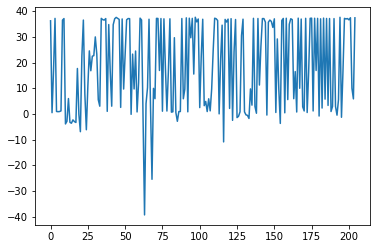

In [24]:
plt.plot(episode_reward)

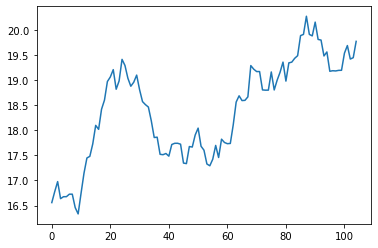

In [25]:
avg_reward = []
sum_reward = 0
span = 100
for i in range(len(episode_reward)):
    if i>=span: sum_reward -= episode_reward[i-span]
    sum_reward += episode_reward[i]
    if i>=span: avg_reward.append(sum_reward/span)
plt.plot(avg_reward)

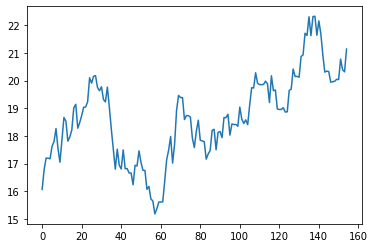

In [28]:
avg_reward = []
sum_reward = 0
span = 50
for i in range(len(episode_reward)):
    if i>=span: sum_reward -= episode_reward[i-span]
    sum_reward += episode_reward[i]
    if i>=span: avg_reward.append(sum_reward/span)
plt.plot(avg_reward)

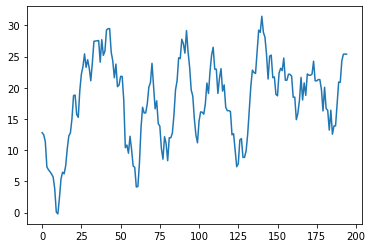

In [29]:
avg_reward = []
sum_reward = 0
span = 10
for i in range(len(episode_reward)):
    if i>=span: sum_reward -= episode_reward[i-span]
    sum_reward += episode_reward[i]
    if i>=span: avg_reward.append(sum_reward/span)
plt.plot(avg_reward)

In [19]:
# agent.save_weights('ddpg_{}_weights.h5f'.format('32_3_rays_final'), overwrite=True)
# actor.save_weights('actor_32_3_rays_final.h5', overwrite=True) 
# critic.save_weights('critic_32_3_rays_final.h5', overwrite=True)

In [1]:
env.make_obstacles()
env.reset()

NameError: name 'env' is not defined

In [19]:
time.sleep(10.)
_ = agent.test(env, nb_episodes=10, visualize=True)

Testing for 10 episodes ...


C:\Users\User\.conda\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Episode 1: reward: 37.311, steps: 434
Episode 2: reward: 37.191, steps: 404
0 0 64.6430942781154
Episode 3: reward: 23.298, steps: 372
0 0 23.051655594175504
Episode 4: reward: 2.783, steps: 154
Episode 5: reward: 37.495, steps: 513
Episode 6: reward: 37.238, steps: 415
Episode 7: reward: 37.384, steps: 548
Episode 8: reward: 37.103, steps: 407
0 0 57.608761726355645
Episode 9: reward: 16.763, steps: 360
Episode 10: reward: 37.264, steps: 462


In [ ]:
# actor.save_weights('actor_32_3_rays_final.h5', overwrite=True) 
# critic.save_weights('critic_32_3_rays_final.h5', overwrite=True)

In [16]:
actor.load_weights('actor_32_3_rays_final.h5')
critic.load_weights('critic_32_3_rays_final.h5')

In [17]:
agent.load_weights('ddpg_{}_weights.h5f'.format('32_3_rays_final'))

In [ ]:
X = []
Y = []

In [ ]:
c = 1
observation = env.reset()
x = []
y = []
while c:
    keys = p.getKeyboardEvents()
    done = 0
    for k,v in keys.items():
        if (k == ord('i') and (v&p.KEY_IS_DOWN   )):
            action = [0]
            x.append(observation)
            y.append(0)
            observation, reward, done, info = env.step(action)
            env.render()
        elif (k == ord('j') and (v&p.KEY_IS_DOWN   )):
            val = 0.5 + random.random()/5 - 0.1
            action = [val]
            x.append(observation)
            y.append(val)
            observation, reward, done, info = env.step(action)
            env.render()
        elif (k == ord('l') and (v&p.KEY_IS_DOWN   )):
            val = -0.5 + random.random()/5 - 0.1
            action = [val]
            x.append(observation)
            y.append(val)
            observation, reward, done, info = env.step(action)
            env.render()
        elif (k == ord('u') and (v&p.KEY_IS_DOWN   )):
            val = 1 + random.random()/5 - 0.1
            action = [val]
            x.append(observation)
            y.append(val)
            observation, reward, done, info = env.step(action)
            env.render()
        elif (k == ord('o') and (v&p.KEY_IS_DOWN   )):
            val = -1 + random.random()/5 - 0.1
            action = [val]
            x.append(observation)
            y.append(val)
            observation, reward, done, info = env.step(action)
            env.render()
        elif (k == ord('r') and (v&p.KEY_IS_DOWN   )):
            c = 0
        if done:
            if env.completed==1:
                X.append(x)
                Y.append(y)
            x = []
            y = []
            observation = env.reset()
            #c = 0
    time.sleep(1/100)

In [ ]:
len(Y), len(Y[49])

In [ ]:
plt.plot([len(x) for x in X])

In [ ]:
for i in range(len(X)):
    print(i, len(X[i]), len(Y[i]))

In [ ]:
# import gym
# import numpy as np

# from stable_baselines.ddpg.policies import MlpPolicy
# from stable_baselines.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec
# from stable_baselines import DDPG

# # the noise objects for DDPG
# n_actions = env.action_space.shape[-1]
# param_noise = None
# action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

# model = DDPG(MlpPolicy, env, verbose=1, param_noise=param_noise, action_noise=action_noise)
# model.learn(total_timesteps=400000)

In [ ]:
X_train = []
y_train = []
for i in range(len(X)):
    for j in range(len(X[i])):
        X_train.append(X[i][j])
        y_train.append(Y[i][j])
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train.shape, y_train.shape

In [ ]:
# np.save('X_train.npy', X_train)
# np.save('y_train.npy', y_train)

In [ ]:
X_train = np.expand_dims(X_train, axis=1)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
actor.fit(X_train, y_train, epochs = 50)